In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
import os
# os.mkdir('TNG-SIM_images/v11_SVR')

In [3]:
# Using the 0D TNG100 SIM data at z=0 (version 3 of the dataset in this notebook, 
# which includes galaxies with log10Mstar=8 and MHI and MH2 are usable features)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v3_TNG-SIM_0D_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v3_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 17)
df_raw.shape (21598, 20)


### <font color='purple'> <a id =10> </a> <br> SVR Complete Raw Dataset

In [4]:
df_raw.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'GroupNsubs',
 'GroupBHMass',
 'Group_M_TopHat200',
 'Group_R_TopHat200',
 'SubhaloMHI',
 'SubhaloMH2',
 'Group_V_TopHat200',
 'GroupSpin_dmo']

Note that when using the 0D dataset, the SVR does not work. From our discussion w Vivi & Ari in Slack, the reason is explained below: 

In the 0D (normalized) dataset the range of the target variable becomes tiny. Since SVRs work by looking for a solution within a certain tolerance, when the values are very small that level of accuracy is reached quickly but it doesn't mean much. This is why the algorithm exits but still produces garbage. For the features this is not a problem because they are scaled before building a model, but the target isn't. The solution is to keep log(GalaxySize) as the target (the halo-unscaled varibale, but logged). With this change, the SVR do really well for both the raw and the dimensionless data [in the TNG300-SAM]

The log solution is better than multiplying the target by 10^3 say, because the distribution of log sizes is much closer to a gaussian (in the TNG-SAM) than the galaxy size/halo size distribution. Hence, log sizes achieve a more stable solution with fewer iterations.

In this notebook I use the unscaled features and logRstar as target.

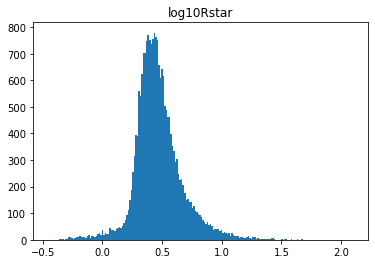

In [7]:
plt.hist(np.log10(df_raw.loc[:,'SubhaloRstar']), bins=200)
plt.title('log10Rstar')
plt.show()

In [8]:
X_all = df_raw.drop(columns=['SubhaloRstar'])
 

y_all = np.log10(df_raw.loc[:,'SubhaloRstar'])

In [9]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params, best score: 0.8413 {'svr__C': 100.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset: 224.312 seconds


Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best params, best score: 0.8413 {'svr__C': 100.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset: 224.312 seconds ~ 3min


In [10]:
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 53.128 seconds


In [11]:
start_time = time.time()

y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Raw Complete Dataset: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Raw Complete Dataset: 54.011 seconds
[CV 3/3] END svr__C=0.1, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.700, test=0.687) total time=   4.1s
[CV 3/3] END svr__C=0.1, svr__gamma=100, svr__kernel=rbf;, score=(train=0.410, test=0.003) total time=  10.5s
[CV 3/3] END svr__C=1.0, svr__gamma=10, svr__kernel=rbf;, score=(train=0.858, test=0.289) total time=  12.7s
[CV 2/3] END svr__C=10.0, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.894, test=0.687) total time=   8.5s
[CV 2/3] END svr__C=10.0, svr__gamma=100, svr__kernel=rbf;, score=(train=0.831, test=-0.003) total time=  22.4s
[CV 3/3] END svr__C=100.0, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.893, test=0.678) total time=  17.9s
[CV 1/3] END svr__C=1000, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.878, test=0.821) total time=  56.0s
[CV 2/3] END svr__C=1000, svr__gamma=10, svr__kernel=rbf;, score=(train=0.859, test=0.287) total time=  

In [12]:
y_pred_SVR_df_all = pd.DataFrame({'y_pred_SVR SIM Raw': y_pred_SVR_all})

y_pred_SVR_df_all.to_csv('TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_y_pred_SVR_predicted_sizes.csv', index=False)

y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_y_pred_SVR_predicted_sizes.csv')

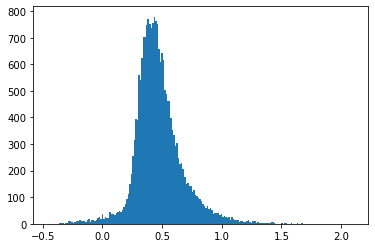

In [13]:
plt.hist(np.log10(df_raw.loc[:, 'SubhaloRstar']), bins=200)
plt.show()

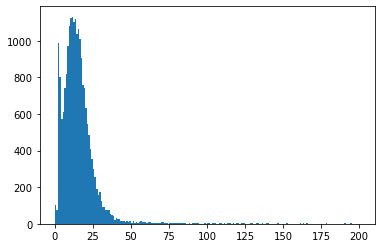

In [15]:
plt.hist(df_raw.loc[:, 'SubhaloVmaxRad'], bins=200, range=(0,200))
plt.show()

### <font color='purple'> <a id =2> </a> <br> SVR predictions vs True Rstar

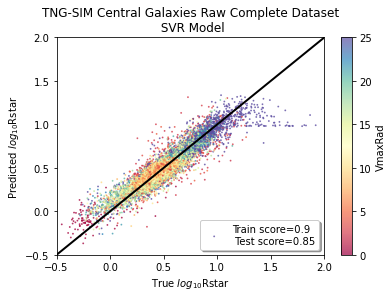

In [33]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )


plt.scatter(np.log10(df_raw.loc[:, 'SubhaloRstar']), y_pred_SVR_all, s=3, marker='.', alpha=0.7, label=label,
                c = df_raw.loc[:, 'SubhaloVmaxRad'],cmap='Spectral', vmin=0.0, vmax=25)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
plt.axis([-0.5,2.0, -0.5,2.0])
plt.plot([-0.5, 2.0], [-0.5, 2.0], color = 'black', linewidth = 2)
plt.title(r'TNG-SIM Central Galaxies Raw Complete Dataset' + '\n SVR Model')
plt.xlabel(r'True $log_{10}$Rstar')
plt.ylabel(r'Predicted $log_{10}$Rstar')
plt.legend(loc='lower right', shadow=True)
plt.colorbar(label=r'VmaxRad')

# plt.savefig("TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_SVR_size_prediction_colorVmaxRad.jpeg", dpi=500)
plt.show()

### <font color='purple'> <a id =3> </a> <br> SVR Learning Curve

In [19]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel("R2 score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

Elapsed time to run SVR Learning Curves on the complete dataset: 27.478 seconds


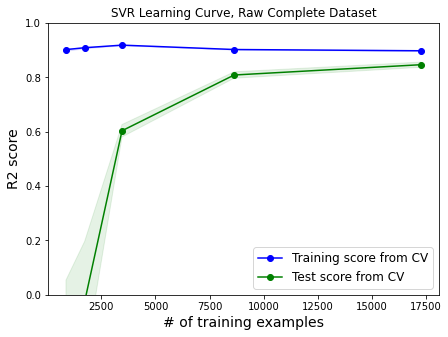

In [30]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR Learning Curve, Raw Complete Dataset', X_all, y_all, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [31]:
# lc_all.savefig('TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_SVR_Learning_Curve.jpeg', dpi=500)

### <font color='purple'> <a id =4> </a> <br> RF predicting log10(Rstar) using raw dataset & its Learning Curve

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.8717 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
RF Accuracy: 0.87 (+/- 0.01)


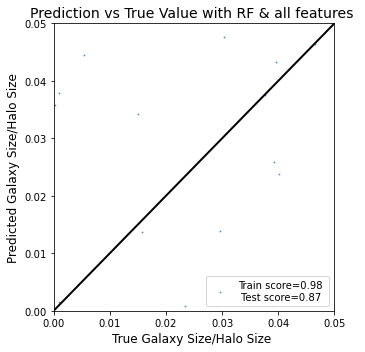

Elapsed time to compute the importances: 0.229 seconds
Elapsed time to compute the importances: 129.911 seconds


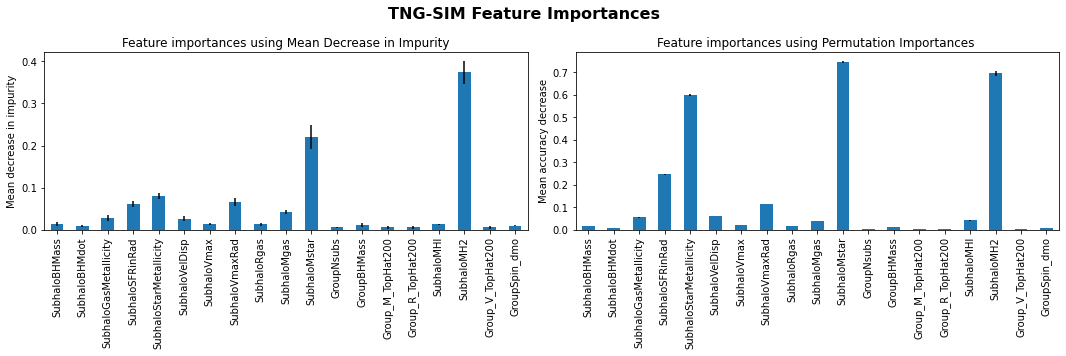

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


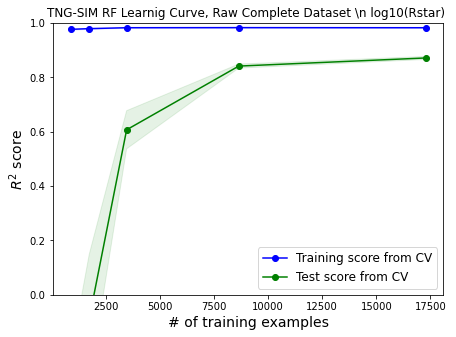

Elapsed time to run RF func and Learning Curves on TNG-SIM 0D Complete Dataset: 2054.435 seconds


In [23]:
# this code takes 2054.435 seconds ~ 34 min to run when the dataset is TNG100-SIM galaxies
# with ~22,000 entries
start_time = time.time()

RF_lc_2 = tp_lc_functions.target_predicting_RF_function(X_all, y_all, r'TNG-SIM RF Learnig Curve, Raw Complete Dataset \n log10(Rstar) ')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: {elapsed_time:.3f} seconds")

In [24]:
y_pred_RF_df_all = RF_lc_2[0]
y_pred_RF_df_all = pd.DataFrame({'y_pred_RF log10(Rstar) SIM Raw': y_pred_RF_df_all})

y_pred_RF_df_all.to_csv('TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_y_pred_RF_predicted_sizes.csv', index=False)

y_pred_RF_all = pd.read_csv('TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_y_pred_RF_predicted_sizes.csv')

In [25]:
lc_2 = RF_lc_2[4]
# lc_2.savefig('TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_RF_Learning_Curve_zoom.jpeg', dpi=500)

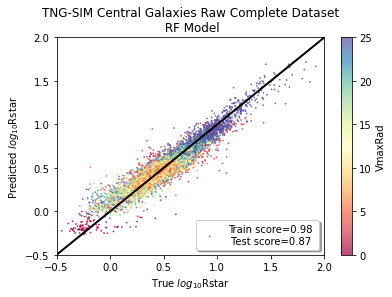

In [32]:
label = 'Train score=0.98 \n Test score=0.87'


plt.scatter(np.log10(df_raw.loc[:, 'SubhaloRstar']), y_pred_RF_all, s=3, marker='.', alpha=0.7, label=label,
                c = df_raw.loc[:, 'SubhaloVmaxRad'],cmap='Spectral', vmin=0.0, vmax=25)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
plt.axis([-0.5,2.0, -0.5,2.0])
plt.plot([-0.5, 2.0], [-0.5, 2.0], color = 'black', linewidth = 2)
plt.title(r'TNG-SIM Central Galaxies Raw Complete Dataset' + '\n RF Model')
plt.xlabel(r'True $log_{10}$Rstar')
plt.ylabel(r'Predicted $log_{10}$Rstar')
plt.legend(loc='lower right', shadow=True)
plt.colorbar(label=r'VmaxRad')

# plt.savefig("TNG-SIM_images/v11_SVR/v11_TNG-SIM_Raw_AllDataset_RF_size_prediction_colorVmaxRad.jpeg", dpi=500)
# plt.show()